<a href="https://colab.research.google.com/github/NatashaKRS/course-portfolio/blob/main/Portfolio_Project_Predicting_writing_quality_from_keystroke_logging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Predicting writing quality from keystroke logging

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import re
import numpy as np
data = pd.read_csv('/content/drive/My Drive/train_logs.csv')

The model we are building is derived from a current Kaggle competition, the idea of which is to predict essay quality from typing behaviour. The details are given as follows: "The goal of this competition is to predict overall writing quality. Does typing behavior affect the outcome of an essay? You will develop a model trained on a large dataset of keystroke logs that have captured writing process features.

Your work will help explore the relationship between learners’ writing behaviors and writing performance, which could provide valuable insights for writing instruction, the development of automated writing evaluation techniques, and intelligent tutoring systems."

The dataset for this competition consists of about 5000 logs of user inputs, such as keystrokes and mouse clicks, taken during the composition of an essay, where each essay was scored on a scale of 0 to 6. The goal of our model is to predict the score an essay received from its log of user inputs.

The data can be found here: https://www.kaggle.com/competitions/linking-writing-processes-to-writing-quality/data



In [3]:
#let's have a a first look
print(data.head(10))
print(f"Total number of typing logs: {data.shape[0]}")

         id  event_id  down_time  up_time  action_time       activity  \
0  001519c8         1       4526     4557           31  Nonproduction   
1  001519c8         2       4558     4962          404  Nonproduction   
2  001519c8         3     106571   106571            0  Nonproduction   
3  001519c8         4     106686   106777           91          Input   
4  001519c8         5     107196   107323          127          Input   
5  001519c8         6     107296   107400          104          Input   
6  001519c8         7     107469   107596          127          Input   
7  001519c8         8     107659   107766          107          Input   
8  001519c8         9     107743   107852          109          Input   
9  001519c8        10     107840   107978          138          Input   

  down_event   up_event text_change  cursor_position  word_count  
0  Leftclick  Leftclick    NoChange                0           0  
1  Leftclick  Leftclick    NoChange                0          

In [4]:
#I want to have a slightly closer look at exactly what the possible values for some of the columns were
print(data["down_event"].unique())
print(data["activity"].unique())
print(data["text_change"].unique())
data.shape

['Leftclick' 'Shift' 'q' 'Space' 'Backspace' '.' ',' 'Enter' 'ArrowLeft'
 "'" ';' 'ArrowRight' '-' '?' 'Tab' '"' 'ArrowUp' 'ArrowDown' 'Rightclick'
 '=' 'CapsLock' 'Control' 'c' 'v' '/' 'Delete' ':' 'z' '[' '$' '(' ')' '+'
 'Home' 'End' '\\' 'Meta' '*' '&' 'AudioVolumeMute' 'x' '!' 'Insert'
 'MediaPlayPause' 'NumLock' '%' 'V' '>' 'Alt' 'AudioVolumeUp'
 'ContextMenu' 'AudioVolumeDown' 'a' '<' 'PageDown' ']' 'Middleclick' '@'
 'F12' 'j' '\x96' 'Dead' 't' 's' 'n' 'y' '{' 'ScrollLock' '¿' 'Process'
 '}' 'MediaTrackPrevious' 'MediaTrackNext' 'F3' '^' 'Unidentified'
 'Cancel' '2' 'i' 'd' 'r' 'e' '`' '\x9b' 'm' '#' '~' 'PageUp' 'T' 'A' 'b'
 'S' 'ModeChange' '_' 'Escape' 'F11' 'Unknownclick' 'AltGraph' 'F10' 'h'
 'F15' 'Clear' 'OS' 'F' 'C' 'o' 'Ä±' 'f' 'u' 'w' 'p' 'g' 'M' 'l' '|'
 'â\x80\x93' 'I' '0' '1' '5' '\x97' 'Ë\x86' '¡' '\x80' 'Â´' 'Å\x9f' 'F2'
 'ä' 'F1' 'Pause' 'F6']
['Nonproduction' 'Input' 'Remove/Cut' 'Replace'
 'Move From [284, 292] To [282, 290]' 'Move From [287, 289] To [285, 287

(8405898, 11)

In [5]:
#Let's also check for NaNs
data.isna().sum()

id                 0
event_id           0
down_time          0
up_time            0
action_time        0
activity           0
down_event         0
up_event           0
text_change        0
cursor_position    0
word_count         0
dtype: int64

In [6]:
# Now let me take a look at those scores
scores = pd.read_csv('/content/drive/My Drive/train_scores.csv') # Adjust path as necessary
scores.head()

,id,score
0,001519c8,3.5
1,0022f953,3.5
2,0042269b,6.0
3,0059420b,2.0
4,0075873a,4.0


In [7]:
# I want to find out a little bit more about the scores
print(scores['score'].unique())
print(scores.describe())
print(f"Total number of scores: {scores.shape[0]}")
print(f"Average number of log entries per essay: {data.shape[0]/scores.shape[0]}")

[3.5 6.  2.  4.  4.5 2.5 5.  3.  1.5 5.5 1.  0.5]
             score
count  2471.000000
mean      3.711251
std       1.024937
min       0.500000
25%       3.000000
50%       4.000000
75%       4.500000
max       6.000000
Total number of scores: 2471
Average number of log entries per essay: 3401.8203156616755


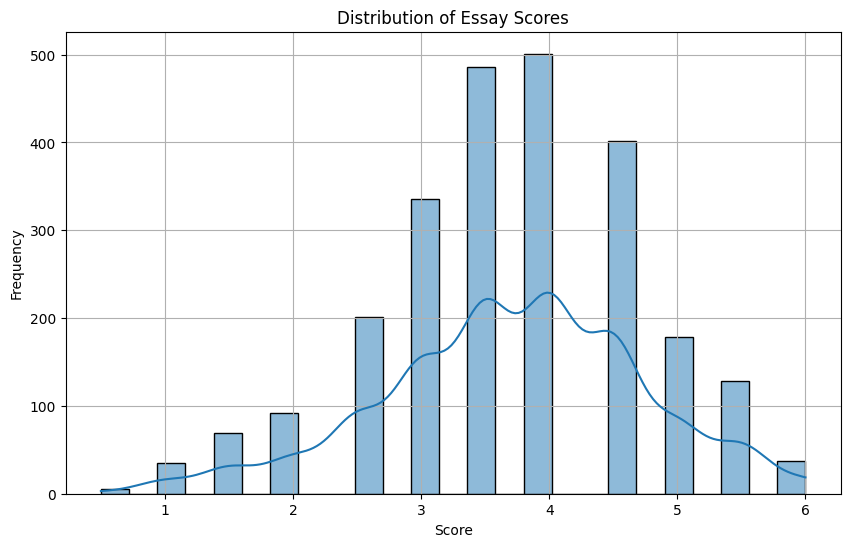

In [8]:
#Let's visualise the distribution of those scores

import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the distribution of scores
plt.figure(figsize=(10, 6))
sns.histplot(scores['score'], kde=True)
plt.title('Distribution of Essay Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



In [9]:
skewness = scores['score'].skew()
# kurtosis
kurtosis = scores['score'].kurtosis()

print(f"Skewness: {skewness}")
print(f"Kurtosis: {kurtosis}")

Skewness: -0.29511654527498904
Kurtosis: 0.0707518073174489


The distribution of essay scores is slightly skewed to the left, indicating a small number of lower scores compared to the right, while the kurtosis close to zero suggests that the distribution's tails are neither exceptionally heavy nor exceptionally light when compared to the normal distribution. This combination indicates a fairly moderate distribution without extreme asymmetry or outliers.


In [10]:
#now let's merge our two datasets on the 'id' column
merged_data = pd.merge(data, scores)
# Display the first few rows of the merged dataframe
print(merged_data.head(20))

          id  event_id  down_time  up_time  action_time       activity  \
0   001519c8         1       4526     4557           31  Nonproduction   
1   001519c8         2       4558     4962          404  Nonproduction   
2   001519c8         3     106571   106571            0  Nonproduction   
3   001519c8         4     106686   106777           91          Input   
4   001519c8         5     107196   107323          127          Input   
5   001519c8         6     107296   107400          104          Input   
6   001519c8         7     107469   107596          127          Input   
7   001519c8         8     107659   107766          107          Input   
8   001519c8         9     107743   107852          109          Input   
9   001519c8        10     107840   107978          138          Input   
10  001519c8        11     108008   108195          187          Input   
11  001519c8        12     108104   108259          155          Input   
12  001519c8        13     108229   10

Clearly, some serious feature engineering will be needed here. For a first quick look at features that might make a difference, why don't we compare an essay with score 6 vs an essay with score 0.5:

In [11]:
# Filter essays with score 6
essays_with_score_6 = merged_data[merged_data['score'] == 6]

# Filter essays with score 0
essays_with_score_low = merged_data[merged_data['score'] == 0.5]

print("Essays with Score 6:")
print(essays_with_score_6.head())

print("\nEssays with Score 0:")
print(essays_with_score_low.head())


Essays with Score 6:
            id  event_id  down_time  up_time  action_time       activity  \
5011  0042269b         1       4441     4540           99  Nonproduction   
5012  0042269b         2      21276    21276            0  Nonproduction   
5013  0042269b         3      21335    21430           95          Input   
5014  0042269b         4      21533    21665          132          Input   
5015  0042269b         5      21594    21742          148          Input   

     down_event   up_event text_change  cursor_position  word_count  score  
5011  Leftclick  Leftclick    NoChange                0           0    6.0  
5012      Shift      Shift    NoChange                0           0    6.0  
5013          q          q           q                1           1    6.0  
5014          q          q           q                2           1    6.0  
5015          q          q           q                3           1    6.0  

Essays with Score 0:
               id  event_id  down_time

Immediately, we can see differences in word productivity and correction behaviour. To further establish what features might be useful for me to extrapolate from the dataset, I embarked on some research on this topic. In particular, this article, published in the International Journal of Artificial Intelligence in Education, titled 'Early prediction of writing quality using keystroke logging': https://rdcu.be/dvfWx was fairly comprehensive and suggested a wide variety of features that might be useful.

Inspired by previous literature such as the example above, this model extrapolates features that can be broadly classed as belonging to the following groups:

1. General, such as word count, session length
2. Revisions, e.g. backspace/delete features
3. Features related to pause timings, such as interkeystroke intervals or timings between words
4. Features related to fluency, such as stats related to so-called 'bursts'
5. Productivity/efficiency, such as overall typing speed and the ratio of production/nonproduction  



Let's start with some general features.

In [12]:
#First of all, all the different unique values in the activity column are of interest
#Let's make them into individual features and also have a single Move column for all the Move options
def activity_types(data):
    # Replace detailed movement activities with a generic 'Move' label
    data['activity'] = data['activity'].str.replace(r'Move From \[.*?\] To \[.*?\]', 'Move', regex=True)

    # Group by 'id' and get value counts of 'activity', unstack and fill missing values
    activity_counts = data.groupby('id')['activity'].value_counts().unstack().fillna(0).reset_index()

    return activity_counts

# Example usage
activities = activity_types(data)
activities.head()


activity,id,Input,Move,Nonproduction,Paste,Remove/Cut,Replace
0,001519c8,2010.0,3.0,120.0,0.0,417.0,7.0
1,0022f953,1938.0,0.0,254.0,1.0,260.0,1.0
2,0042269b,3515.0,0.0,175.0,0.0,439.0,7.0
3,0059420b,1304.0,0.0,99.0,1.0,151.0,1.0
4,0075873a,1942.0,0.0,72.0,0.0,517.0,0.0


In [13]:
def session_length(data):
    # Calculate the min down_time and max up_time for each essay
    session_len = data.groupby('id').agg({'down_time': 'min', 'up_time': 'max'})

    # Calculate total session time for each essay
    session_len['total_session_time'] = session_len['up_time'] - session_len['down_time']

    # Reset index to make 'id' a column
    session_len = session_len.reset_index()[['id', 'total_session_time']]

    return session_len

# Using the function
session_time_data = session_length(data)
session_time_data.head()


,id,total_session_time
0,001519c8,1797443
1,0022f953,1758346
2,0042269b,1767228
3,0059420b,1363074
4,0075873a,1584002


In [14]:
def max_word_count(data):
    max_word_count_data = data.groupby('id')['word_count'].max().reset_index()
    return max_word_count_data

# Using the function
max_word_data = max_word_count(data)
max_word_data.head()


,id,word_count
0,001519c8,256
1,0022f953,323
2,0042269b,404
3,0059420b,206
4,0075873a,252


In [15]:

def average_word_length(data):
    # Concatenate down_event strings for each id
    concatenated_events = data.groupby('id')['down_event'].apply(lambda x: ''.join(x))

    # Nested function to find consecutive 'q's and calculate their mean length
    def mean_consecutive_qs(events_string):
        consecutive_qs = re.findall(r'q+', events_string)
        if consecutive_qs:
            return np.mean([len(s) for s in consecutive_qs])
        return 0

    # Apply the function to each concatenated string
    mean_qs_per_id = concatenated_events.apply(mean_consecutive_qs)

    # Convert the series into a DataFrame
    mean_qs_df = mean_qs_per_id.reset_index()
    mean_qs_df.columns = ['id', 'mean_consecutive_qs']

    return mean_qs_df

# Using the function
average_word_length_data = average_word_length(data)
print(f"mean average word length: {average_word_length_data['mean_consecutive_qs'].mean()}") #we will need this later")
average_word_length_data.head()


mean average word length: 4.158183874958281


,id,mean_consecutive_qs
0,001519c8,4.260526
1,0022f953,3.616505
2,0042269b,4.737357
3,0059420b,3.830258
4,0075873a,4.065963


In [16]:
#and also the max word length
import re

def max_word_length(data):
    # Concatenate down_event strings for each id
    concatenated_events = data.groupby('id')['down_event'].apply(lambda x: ''.join(x))

    # Nested function to find consecutive 'q's and calculate their maximum length
    def max_consecutive_qs(events_string):
        consecutive_qs = re.findall(r'q+', events_string)
        if consecutive_qs:
            return np.max([len(s) for s in consecutive_qs])
        return 0

    # Apply the function to each concatenated string
    max_qs_per_id = concatenated_events.apply(max_consecutive_qs)

    # Convert the series into a DataFrame
    max_qs_df = max_qs_per_id.reset_index()
    max_qs_df.columns = ['id', 'max_consecutive_qs']

    return max_qs_df

# Using the function
max_word_length_data = max_word_length(data)
max_word_length_data.head()


,id,max_consecutive_qs
0,001519c8,11
1,0022f953,13
2,0042269b,13
3,0059420b,13
4,0075873a,12


Next, I want to look at events that have to do with revision, i.e. the use of backspace/delete, paste and jump etc.

In [17]:
def correction_frequency(data):
    # Count correction keystrokes
    data['correction_count'] = data['down_event'].apply(lambda x: 1 if x in ['Backspace', 'Delete'] else 0)

    # Sum correction counts by 'id'
    correction_freq = data.groupby('id')['correction_count'].sum().reset_index()

    return correction_freq

# Example usage
corrections = correction_frequency(data)
corrections.head()


,id,correction_count
0,001519c8,417
1,0022f953,260
2,0042269b,439
3,0059420b,152
4,0075873a,517


In [18]:
def backspace_stats(data):
  data['is_single_backspace'] = data['down_event'].isin(['Backspace', 'Delete']) & \
                              data['down_event'].shift(-1) != data['down_event']

# Filtering for single backspacing events
  single_backspaces = data[data['is_single_backspace']]

# Calculating the duration of single backspacing events (assuming 'up_time' - 'down_time')
  single_backspaces['backspace_duration'] = single_backspaces['up_time'] - single_backspaces['down_time']

# Calculating mean and SD of time in single backspacing for each essay
  mean_single_backspacing = single_backspaces.groupby('id')['backspace_duration'].mean().reset_index()
  mean_single_backspacing.rename(columns={'backspace_duration': 'mean_single_backspacing'}, inplace=True)

  sd_single_backspacing = single_backspaces.groupby('id')['backspace_duration'].std().reset_index()
  sd_single_backspacing.rename(columns={'backspace_duration': 'sd_single_backspacing'}, inplace=True)
  backspace_df = pd.merge(mean_single_backspacing, sd_single_backspacing, on='id')

  return backspace_df

# Displaying the first few rows of the calculated features
backspace_df = backspace_stats(data)
backspace_df.head()


,id,mean_single_backspacing,sd_single_backspacing
0,001519c8,116.246774,91.797374
1,0022f953,112.221271,55.431189
2,0042269b,101.837766,82.383766
3,0059420b,121.848329,113.768226
4,0075873a,123.943896,62.082013


In [19]:
def paste_jump_events(data):
# Simplifying the calculation for paste/jump events using 'data'
  paste_jump_events = data[data['activity'].isin(['Remove/Cut', 'Move From To'])]

# Calculating mean and SD of 'action_time' for paste/jump events, grouped by 'id'
  event_stats = paste_jump_events.groupby('id')['action_time'].agg(['mean', 'std']).reset_index()

# column names
  event_stats.rename(columns={'mean': 'mean_paste_jump', 'std': 'sd_paste_jump'}, inplace=True)

  return event_stats

paste_jumps = paste_jump_events(data)
paste_jumps.head()

,id,mean_paste_jump,sd_paste_jump
0,001519c8,81.846523,73.711727
1,0022f953,90.576923,35.787525
2,0042269b,74.954442,64.854264
3,0059420b,121.920530,132.024418
4,0075873a,77.754352,102.041485


Next, features related to gaps and pauses, whether that be between keystrokes, words etc.

In [20]:
def calculate_gaps(group):
    group = group.sort_values('down_time')
    group['previous_up_time'] = group['up_time'].shift(1)
    group['gap'] = group['down_time'] - group['previous_up_time']
    return group

def max_gaps_per_essay(data):
    # Apply the calculate_gaps function to each group
    optimized_data = data.groupby('id').apply(calculate_gaps)

    # Replace negative gaps with 0 and set gap for the first event of each essay as NaN
    optimized_data['gap'] = optimized_data['gap'].apply(lambda x: max(x, 0) if pd.notnull(x) else np.nan)

    # Reset the index of optimized_data
    optimized_data_reset = optimized_data.reset_index(drop=True)

    # Calculate the maximum gap for each essay
    max_gaps = optimized_data_reset.groupby('id')['gap'].max().reset_index()

    return max_gaps

max_gaps_data = max_gaps_per_essay(data)
max_gaps_data.head()


,id,gap
0,001519c8,154136.0
1,0022f953,145899.0
2,0042269b,153886.0
3,0059420b,101690.0
4,0075873a,110688.0


In [21]:
def initial_pause_time(data):
    # Calculate Initial Pause Time for each essay
    initial_pause = data.groupby('id')['down_time'].min().reset_index()
    initial_pause.rename(columns={'down_time': 'initial_pause_time'}, inplace=True)

    return initial_pause

# Using the function
initial_pause_data = initial_pause_time(data)
initial_pause_data.head()


,id,initial_pause_time
0,001519c8,4526
1,0022f953,30623
2,0042269b,4441
3,0059420b,41395
4,0075873a,78470


In [22]:
def IKI_stats(data):
    # Calculate Interkeystroke Interval (IKI)
    data['next_down_time'] = data.groupby('id')['down_time'].shift(-1)
    data['IKI'] = data['next_down_time'] - data['down_time']

    # Filter out negative IKIs which can occur due to shifting across different ids
    filtered_data = data[data['IKI'] >= 0]

    # Group by id and calculate summary statistics for IKI
    IKI_statistics = filtered_data.groupby('id')['IKI'].agg(['mean', 'median', 'max', 'min', 'std']).reset_index()
    IKI_statistics.rename(columns={'max': 'IKI_max', 'min': 'IKI_min', 'mean': 'IKI_mean', 'median': 'IKI_median', 'std': 'IKI_std'}, inplace=True)

    return IKI_statistics

# Using the function
IKI_stats_data = IKI_stats(data)
IKI_stats_data.head()


,id,IKI_mean,IKI_median,IKI_max,IKI_min,IKI_std
0,001519c8,703.188967,151.0,154173.0,10.0,4296.265374
1,0022f953,716.762740,160.0,145968.0,13.0,4895.361707
2,0042269b,427.274002,94.0,153955.0,2.0,3939.697088
3,0059420b,876.526688,256.0,101808.0,1.0,4248.876748
4,0075873a,626.055336,166.5,110824.0,9.0,3897.155465


In [23]:
#Looking at IKI ranges
def IKI_ranges(data):
    # Define the IKI time ranges
    iki_ranges = [(500, 1000), (1000, 1500), (1500, 2000), (2000, 3000), (3000, float('inf'))]

    # Initialize a dictionary to hold the counts for each range
    iki_range_counts = {f'IKI_{start}_{end}': [] for start, end in iki_ranges}

    # Calculate the counts for each range
    for start, end in iki_ranges:
        column_name = f'IKI_{start}_{end}'
        iki_range_counts[column_name] = data.groupby('id').apply(
            lambda x: x['IKI'].between(start, end).sum()
        ).reset_index(name=column_name)

    # Merging all the IKI range count dataframes
    merged_iki_ranges = pd.DataFrame({'id': data['id'].unique()})
    for df in iki_range_counts.values():
        merged_iki_ranges = pd.merge(merged_iki_ranges, df, on='id', how='left')

    return merged_iki_ranges

# Using the function
IKI_range_data = IKI_ranges(data)
IKI_range_data.head()


,id,IKI_500_1000,IKI_1000_1500,IKI_1500_2000,IKI_2000_3000,IKI_3000_inf
0,001519c8,162,61,29,31,104
1,0022f953,175,54,17,22,63
2,0042269b,126,50,32,28,56
3,0059420b,219,109,46,35,59
4,0075873a,109,34,12,19,73


In [24]:
#IKI stats within words
def calculate_IKI_within_word(data):
    # Calculate IKI for each keystroke
    data['IKI'] = data.groupby('id')['down_time'].diff()

    # Identify word keystrokes (assuming 'q' represents a word keystroke)
    data['is_word_keystroke'] = data['down_event'] == 'q'

    # Filter IKIs within words
    IKI_within_words = data[data['is_word_keystroke']]

    # Calculate mean IKI within words for each essay
    mean_IKI_within_word = IKI_within_words.groupby('id')['IKI'].mean().reset_index()
    mean_IKI_within_word.rename(columns={'IKI': 'mean_IKI_within_word'}, inplace=True)

    # Calculate SD IKI within words for each essay
    sd_IKI_within_word = IKI_within_words.groupby('id')['IKI'].std().reset_index()
    sd_IKI_within_word.rename(columns={'IKI': 'sd_IKI_within_word'}, inplace=True)

    # Merging the mean and SD dataframes
    IKI_within_word_stats = pd.merge(mean_IKI_within_word, sd_IKI_within_word, on='id')

    return IKI_within_word_stats

# Using the function
IKI_within_word_data = calculate_IKI_within_word(data)
IKI_within_word_data.head()


,id,mean_IKI_within_word,sd_IKI_within_word
0,001519c8,393.961705,1318.894640
1,0022f953,252.463087,440.166781
2,0042269b,179.092975,1436.315202
3,0059420b,714.656069,1796.728223
4,0075873a,254.243997,519.457744


In [25]:
def calculate_IKI_between_words(data):
    # Identifying IKIs that occur between words
    data['word_count_change'] = data['word_count'].diff()
    IKI_between_words = data[(data['word_count_change'] > 0) & (data['down_event'] == 'Space')]['IKI']

    # Group by id and calculate the mean and SD of IKI between words
    IKI_between_words_stats = IKI_between_words.groupby(data['id']).agg(['mean', 'std']).reset_index()
    IKI_between_words_stats.rename(columns={'mean': 'IKI_between_words_mean', 'std': 'IKI_between_words_sd'}, inplace=True)

    return IKI_between_words_stats

# Using the function
IKI_between_words_data = calculate_IKI_between_words(data)
IKI_between_words_data.head()


,id,IKI_between_words_mean,IKI_between_words_sd
0,001519c8,244.000000,240.676632
1,0022f953,300.744186,562.248127
2,0042269b,127.950413,228.976546
3,0059420b,429.107143,1576.255698
4,0075873a,372.017544,1066.850262


In [26]:
# Long pause data, where a long pause is understood to be > 2000 milliseconds
# Identify word keystrokes
def long_pause_data(data):
  data['is_word_keystroke'] = data['down_event'] == 'q'
  data['is_pause'] = ~data['is_word_keystroke']
  pause_IKIs = data[data['is_pause']]

# Define a threshold for long pauses (example: 2000 milliseconds)
  long_pause_threshold = 2000
  long_pauses = pause_IKIs.groupby('id').apply(lambda x: (x['IKI'] > long_pause_threshold).sum()).reset_index()
  long_pauses.rename(columns={0: 'long_pauses'}, inplace=True)

  total_pauses = pause_IKIs.groupby('id').size().reset_index(name='total_pauses')

# Merge long pauses and total pauses, then calculate the percentage
  long_pause_data = pd.merge(long_pauses, total_pauses, on='id')
  long_pause_data['percentage_long_pauses'] = (long_pause_data['long_pauses'] / long_pause_data['total_pauses']) * 100
  long_pause_data = long_pause_data.drop(columns=['long_pauses'])
  return long_pause_data

long_pause_df = long_pause_data(data)
long_pause_df.head()

,id,total_pauses,percentage_long_pauses
0,001519c8,938,8.955224
1,0022f953,964,7.468880
2,0042269b,1232,5.357143
3,0059420b,518,6.563707
4,0075873a,990,7.272727


In [27]:
#Let's look at intervals between the completion of words
def word_interval_data(data):
    # Identifying points where word count increases
    data['word_count_change'] = data.groupby('id')['word_count'].diff()
    word_completion_points = data[data['word_count_change'] > 0]

    # Calculating the pause lengths
    word_completion_points['pause_length'] = word_completion_points.groupby('id')['down_time'].diff()

    # Removing the first occurrence of a word count increase for each 'id'
    word_completion_points_cleaned = word_completion_points.dropna(subset=['pause_length'])

    # Calculating average, max, min, and standard deviation of pause lengths for each 'id'
    average_word_interval = word_completion_points_cleaned.groupby('id')['pause_length'].mean().reset_index()
    max_pause = word_completion_points_cleaned.groupby('id')['pause_length'].max().reset_index()
    min_pause = word_completion_points_cleaned.groupby('id')['pause_length'].min().reset_index()
    std_dev_pause_length = word_completion_points_cleaned.groupby('id')['pause_length'].std().reset_index()

    # Renaming columns for clarity
    average_word_interval.rename(columns={'pause_length': 'avg_word_interval'}, inplace=True)
    max_pause.rename(columns={'pause_length': 'max_pause_length'}, inplace=True)
    min_pause.rename(columns={'pause_length': 'min_pause_length'}, inplace=True)
    std_dev_pause_length.rename(columns={'pause_length': 'std_dev_pause_length'}, inplace=True)

    # Merging all the results into a single DataFrame
    interval_data = pd.merge(average_word_interval, max_pause, on='id')
    interval_data = pd.merge(interval_data, min_pause, on='id')
    interval_data = pd.merge(interval_data, std_dev_pause_length, on='id')

    return interval_data

# Using the function
word_interval_stats = word_interval_data(data)
word_interval_stats.head()


<ipython-input-27-dcbf5522ea64>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  word_completion_points['pause_length'] = word_completion_points.groupby('id')['down_time'].diff()


,id,avg_word_interval,max_pause_length,min_pause_length,std_dev_pause_length
0,001519c8,4711.020173,178360.0,249.0,12164.796336
1,0022f953,4291.448370,280270.0,200.0,19978.127037
2,0042269b,3189.673358,186995.0,162.0,13505.743259
3,0059420b,5101.913580,178385.0,293.0,12685.806713
4,0075873a,4614.026627,112913.0,273.0,11715.983893


In [28]:
# next, stats to do with the time between words
def inbetween_words(data):
    data['is_word_end'] = data['down_event'] == 'Space'
    data['is_word_start'] = (data['down_event'] == 'q') & (data.groupby('id')['word_count'].diff() > 0)

    # Capture the down_time of the next word start
    data['next_word_start_time'] = data[data['is_word_start']]['down_time']
    data['next_word_start_time'] = data.groupby('id')['next_word_start_time'].shift(-1)

    # Calculate time to next word start only at word end points
    data['time_to_next_word'] = data[data['is_word_end']]['next_word_start_time'] - data[data['is_word_end']]['down_time']

    # Calculate mean and standard deviation for each 'id'
    mean_time_to_next_word = data.groupby('id')['time_to_next_word'].mean().reset_index(name='mean_time_to_next_word')
    std_time_to_next_word = data.groupby('id')['time_to_next_word'].std().reset_index(name='std_time_to_next_word')

    # Merging the mean and std dataframes
    interval_stats = pd.merge(mean_time_to_next_word, std_time_to_next_word, on='id')

    return interval_stats

# Using the function
interval_stats_data = inbetween_words(data)
interval_stats_data.head()


,id,mean_time_to_next_word,std_time_to_next_word
0,001519c8,1239.019157,2775.466312
1,0022f953,414.489437,839.045522
2,0042269b,196.129630,357.539128
3,0059420b,1940.402116,2770.669488
4,0075873a,548.804000,1163.703183


Data relating to fluency, in particular so-called bursts, which are generally defined as sequences of rapid text production without a long pause or revisions

In [29]:
def burst_summary(data):
    # Define revision events
    revision_events = data['down_event'].isin(['Backspace', 'Delete'])

    # Identifying bursts
    data['in_burst'] = ((data['IKI'] <= 9000) & ~revision_events).astype(int)

    # Identifying the start and end of a new burst
    data['burst_start'] = (~data['in_burst'].shift(1, fill_value=0).astype(bool)) & data['in_burst'].astype(bool)
    data['burst_end'] = (~data['in_burst'].shift(-1, fill_value=0).astype(bool)) & data['in_burst'].astype(bool)

    # Assigning a burst sequence number
    data['burst_sequence'] = data['burst_start'].cumsum()

    # Calculate word count at the start and end of each burst
    data['word_count_start'] = data['word_count'].where(data['burst_start']).ffill()
    data['word_count_end'] = data['word_count'].where(data['burst_end'])

    # Calculate the words in each burst
    data['words_in_burst'] = data['word_count_end'] - data['word_count_start']

    # Group by id and burst sequence to calculate burst features
    burst_features = data[data['in_burst'] == 1].groupby(['id', 'burst_sequence']).agg(
        burst_length=('IKI', 'count'),
        words_in_burst=('words_in_burst', 'first')
    ).reset_index()

    # Fill NaN values in 'words_in_burst' with 0
    burst_features['words_in_burst'].fillna(0, inplace=True)

    # Calculating summary statistics for bursts
    burst_stats = burst_features.groupby('id').agg(
        num_bursts=('burst_sequence', 'nunique'),
        avg_burst_length=('burst_length', 'mean'),
        avg_words_per_burst=('words_in_burst', 'mean')
    ).reset_index()

    return burst_stats

# Using the function
burst_summary_data = burst_summary(data)
burst_summary_data.head()


,id,num_bursts,avg_burst_length,avg_words_per_burst
0,001519c8,114,18.561404,2.535088
1,0022f953,104,20.759615,3.365385
2,0042269b,112,32.794643,4.357143
3,0059420b,78,17.769231,2.820513
4,0075873a,69,28.797101,4.565217


In [30]:
def p_burst_summary(data):
    # Define revision events
    revision_events = data['down_event'].isin(['Backspace', 'Delete'])

    # Identifying bursts and long pauses
    data['in_burst'] = ((data['IKI'] <= 9000) & ~revision_events).astype(int)
    long_pause = data['IKI'] > 3000

    # Identifying the start and end of a new P-burst
    data['p_burst_start'] = long_pause.shift(1, fill_value=True) & data['in_burst']
    data['p_burst_end'] = long_pause.shift(-1, fill_value=True) & data['in_burst']

    # Assigning a P-burst sequence number
    data['p_burst_sequence'] = data['p_burst_start'].cumsum()

    # Calculate word count at the start and end of each P-burst
    data['word_count_start'] = data['word_count'].where(data['p_burst_start']).ffill()
    data['word_count_end'] = data['word_count'].where(data['p_burst_end'])

    # Calculate the words in each P-burst
    data['words_in_p_burst'] = data['word_count_end'] - data['word_count_start']

    # Group by id and P-burst sequence to calculate P-burst features
    p_burst_features = data[data['in_burst'] == 1].groupby(['id', 'p_burst_sequence']).agg(
        p_burst_length=('IKI', 'count'),
        words_in_p_burst=('words_in_p_burst', 'first')
    ).reset_index()

    # Fill NaN values in 'words_in_p_burst' with 0
    p_burst_features['words_in_p_burst'].fillna(0, inplace=True)

    # Calculating summary statistics for P-bursts
    p_burst_stats = p_burst_features.groupby('id').agg(
        num_p_bursts=('p_burst_sequence', 'nunique'),
        avg_p_burst_length=('p_burst_length', 'mean'),
        avg_words_per_p_burst=('words_in_p_burst', 'mean')
    ).reset_index()

    # Calculate the total words in P-bursts for each id
    total_words_in_p_bursts = p_burst_features.groupby('id')['words_in_p_burst'].sum().reset_index()
    total_words_in_p_bursts.rename(columns={'words_in_p_burst': 'total_words_in_p_bursts'}, inplace=True)

    # Calculate the total word count for each id
    total_word_count = data.groupby('id')['word_count'].max().reset_index()

    # Merge the datasets
    combined_data = pd.merge(p_burst_stats, total_words_in_p_bursts, on='id', how='left')
    combined_data = pd.merge(combined_data, total_word_count, on='id', how='left')

    # Calculate the percentage of words in P-bursts
    combined_data['percentage_words_in_p_bursts'] = (combined_data['total_words_in_p_bursts'] /
                                                     combined_data['word_count']) * 100
    combined_data.drop('word_count', axis = 1, inplace = True)
    return combined_data

# Using the function
combined_p_burst_data = p_burst_summary(data)
combined_p_burst_data.head()




,id,num_p_bursts,avg_p_burst_length,avg_words_per_p_burst,total_words_in_p_bursts,percentage_words_in_p_bursts
0,001519c8,78,27.128205,2.448718,191.0,74.609375
1,0022f953,47,45.936170,0.638298,30.0,9.287926
2,0042269b,44,83.477273,9.090909,400.0,99.009901
3,0059420b,50,27.720000,3.140000,157.0,76.213592
4,0075873a,41,48.463415,5.439024,223.0,88.492063


Finally, let's define some features relating to efficiency and productivity.

In [31]:
def content_rate(data):
    # Filter out events with zero duration
    non_zero_events = data[data['action_time'] > 0].copy()

    # Calculate character change rate (characters per minute)
    non_zero_events['content_speed'] = non_zero_events['text_change'].str.len() / (non_zero_events['action_time'] / 60000)

    # Group by 'id' and calculate average content rate
    content_rate = non_zero_events.groupby('id')['content_speed'].mean().reset_index()

    return content_rate

# Example usage
speed = content_rate(data)
speed.head()


,id,content_speed
0,001519c8,2061.590977
1,0022f953,1409.372971
2,0042269b,940.510131
3,0059420b,7372.652931
4,0075873a,766.523757


In [32]:
def typing_speed(data):
    # Filter out specific typing events with valid, non-zero action_time
    typing_events = data[(data['down_event'] == 'q') & (data['action_time'] > 0)].copy()

    # Calculate typing speed (keystrokes per minute)
    typing_events['typing_speed'] = 1 / (typing_events['action_time'] / 60000)

    # Group by 'id' and calculate average typing speed
    avg_typing_speed = typing_events.groupby('id')['typing_speed'].mean().reset_index()

    return avg_typing_speed

speed_data = typing_speed(data)
speed_data.head()


,id,typing_speed
0,001519c8,522.698861
1,0022f953,545.079134
2,0042269b,659.979887
3,0059420b,6338.959562
4,0075873a,446.660441


In [33]:
#next, we will calculate the so - called efficiency, as well as the related feature of words per keystroke
# the efficiency calculates the ratio of the final number of characters to the number of characters that was actually typed
# we're going to make use of the fact that the mean of the average word length column calculated earlier is approximately 4.16
def calculate_efficiency(data):
    # Step 1: Calculate characters removed for 'Remove/Cut' events
    remove_cut_events = data[data['activity'] == 'Remove/Cut'].copy()
    remove_cut_events.loc[:, 'word_count_change'] = remove_cut_events.groupby('id')['word_count'].diff().fillna(0)
    remove_cut_events = remove_cut_events[remove_cut_events['word_count_change'] < 0]
    remove_cut_events.loc[:, 'chars_removed'] = remove_cut_events['word_count_change'].abs() * 4.16
    chars_removed_per_essay = remove_cut_events.groupby('id')['chars_removed'].sum().reset_index()

    # Step 2: Count the occurrences of 'q' in down events for each essay
    data['is_q'] = data['down_event'] == 'q'
    q_count_per_essay = data.groupby('id')['is_q'].sum().reset_index()

    # Step 3: Aggregate data at the essay level using the last recorded word count
    efficiency_data = data.groupby('id').agg({'word_count': 'last'}).reset_index()
    efficiency_data.rename(columns={'word_count': 'final_word_count'}, inplace=True)

    # Step 4: Calculate estimated final characters
    efficiency_data['estimated_final_chars'] = efficiency_data['final_word_count'] * 4.16 #this

    # Step 5: Merge the characters removed data and q_count
    efficiency_data = efficiency_data.merge(chars_removed_per_essay, on='id', how='left')
    efficiency_data = efficiency_data.merge(q_count_per_essay.rename(columns={'is_q': 'total_typed_chars_count'}), on='id')
    efficiency_data['chars_removed'].fillna(0, inplace=True)

    efficiency_data['words_per_keystroke'] = (efficiency_data['final_word_count'] /
                                                     efficiency_data['total_typed_chars_count'])
    # Step 6: Recalculate efficiency using the updated 'total_typed_chars_count'
    efficiency_data['efficiency'] = efficiency_data['estimated_final_chars'] / efficiency_data['total_typed_chars_count']
    efficiency_data.drop('estimated_final_chars', axis = 1, inplace = True)
    return efficiency_data

# Using the function
efficiency_data = calculate_efficiency(data)
efficiency_data.head()


,id,final_word_count,chars_removed,total_typed_chars_count,words_per_keystroke,efficiency
0,001519c8,255,274.56,1619,0.157505,0.655219
1,0022f953,320,153.92,1490,0.214765,0.893423
2,0042269b,404,349.44,2904,0.139118,0.578733
3,0059420b,206,83.20,1038,0.198459,0.825588
4,0075873a,252,324.48,1541,0.163530,0.680286


In [34]:
def calculate_productivity(data):
    # Define input and non-input activities
    input_activity = 'Input'
    non_input_activities = ['Remove/Cut', 'Nonproduction']

    # Count input and non-input activities
    activity_counts = data.groupby(['id', 'activity']).size().unstack(fill_value=0)

    # Calculate total input and non-input activities
    activity_counts['Total_Input'] = activity_counts[input_activity]
    activity_counts['Total_Non_Input'] = activity_counts[non_input_activities].sum(axis=1)

    # Calculate the ratio of input to non-input activities
    activity_counts['Input_NonInput_Ratio'] = activity_counts['Total_Input'] / activity_counts['Total_Non_Input'].replace(0, 1)

    # Reset index to prepare for merging
    ratio_df = activity_counts[['Input_NonInput_Ratio']].reset_index()

    return ratio_df

# Using the function
productivity_data = calculate_productivity(data)
productivity_data.head()


activity,id,Input_NonInput_Ratio
0,001519c8,3.743017
1,0022f953,3.770428
2,0042269b,5.724756
3,0059420b,5.216000
4,0075873a,3.297114


In [35]:
#keystroke data
from scipy.stats import entropy

def calculate_entropy(values):
    value_counts = np.bincount(values)
    return entropy(value_counts)

def keystroke_stats(data):
    # Assuming 'down_time' represents the timestamp of each keystroke in milliseconds
    # Converting 'down_time' to seconds for ease of interval calculation
    data['time_seconds'] = data['down_time'] / 1000

    # Segmenting data into 30-second intervals
    data['time_interval'] = data['time_seconds'] // 30

    # Calculating the number of keystrokes per 30-second interval for each essay
    keystrokes_per_interval = data.groupby(['id', 'time_interval']).size().unstack(fill_value=0)

    # Calculating entropy, uniformity, and slope for each essay
    keystrokes_entropy = keystrokes_per_interval.apply(calculate_entropy, axis=1).reset_index(name='entropy_keystrokes')
    keystrokes_uniformity = keystrokes_per_interval.apply(lambda x: entropy(x, base=2), axis=1).reset_index(name='uniformity_keystrokes')
    keystrokes_slope = keystrokes_per_interval.apply(lambda x: np.polyfit(x.index, x, 1)[0], axis=1).reset_index(name='slope_keystrokes')

    # Calculate the total keystrokes per essay
    total_keystrokes = data.groupby('id').size().reset_index(name='total_keystrokes')

    # Merge all statistics DataFrames into one
    merged_df = keystrokes_entropy.merge(keystrokes_uniformity, on=['id'])
    merged_df = merged_df.merge(keystrokes_slope, on=['id'])
    merged_df = merged_df.merge(total_keystrokes, on=['id'])

    return merged_df


stats = keystroke_stats(data)
stats


,id,entropy_keystrokes,uniformity_keystrokes,slope_keystrokes,total_keystrokes
0,001519c8,1.523890,5.413728,-0.177681,2557
1,0022f953,1.290101,4.945103,-0.192294,2454
2,0042269b,1.363170,5.112334,-0.289531,4136
3,0059420b,1.143076,5.140820,-0.110755,1556
4,0075873a,1.343271,5.157509,-0.185069,2531
...,...,...,...,...,...
2466,ffb8c745,1.311490,5.225793,-0.343519,4739
2467,ffbef7e5,1.455412,5.362571,-0.181348,2604
2468,ffccd6fd,1.472765,4.942382,-0.181196,3063
2469,ffec5b38,1.232938,5.166358,-0.249027,3242


Now it's time to put everything together - let's create a preprocess function that will apply all our above functions to the data, aggregate the dataframes and deal with any NaNs.

In [36]:
# List of functions that return DataFrames
functions = [activity_types, session_length, correction_frequency, typing_speed, content_rate, max_word_count, max_gaps_per_essay,
            average_word_length, max_word_length, IKI_stats, IKI_ranges, inbetween_words, word_interval_data, initial_pause_time,
             burst_summary, p_burst_summary, long_pause_data, backspace_stats, calculate_IKI_between_words, calculate_IKI_within_word,
            calculate_efficiency, keystroke_stats, calculate_productivity, paste_jump_events]

# Initialize the aggregated DataFrame with the 'id' column
def preprocess(data):
  final_data = pd.DataFrame(data={'id': data['id'].unique()})

# Loop through the functions and merge the returned DataFrames on 'id'
  for func in functions:
    result_df = func(data)
    final_data = pd.merge(final_data, result_df, on='id', how='left')

# replace NaNs
  final_data.fillna(0, inplace = True)

  return final_data

# Check the first few rows of the merged dataset
final_df = preprocess(data)

print(final_df.columns)

final_df.head(10)

<ipython-input-27-dcbf5522ea64>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  word_completion_points['pause_length'] = word_completion_points.groupby('id')['down_time'].diff()


Index(['id', 'Input', 'Move', 'Nonproduction', 'Paste', 'Remove/Cut',
       'Replace', 'total_session_time', 'correction_count', 'typing_speed',
       'content_speed', 'word_count', 'gap', 'mean_consecutive_qs',
       'max_consecutive_qs', 'IKI_mean', 'IKI_median', 'IKI_max', 'IKI_min',
       'IKI_std', 'IKI_500_1000', 'IKI_1000_1500', 'IKI_1500_2000',
       'IKI_2000_3000', 'IKI_3000_inf', 'mean_time_to_next_word',
       'std_time_to_next_word', 'avg_word_interval', 'max_pause_length',
       'min_pause_length', 'std_dev_pause_length', 'initial_pause_time',
       'num_bursts', 'avg_burst_length', 'avg_words_per_burst', 'num_p_bursts',
       'avg_p_burst_length', 'avg_words_per_p_burst',
       'total_words_in_p_bursts', 'percentage_words_in_p_bursts',
       'total_pauses', 'percentage_long_pauses', 'mean_single_backspacing',
       'sd_single_backspacing', 'IKI_between_words_mean',
       'IKI_between_words_sd', 'mean_IKI_within_word', 'sd_IKI_within_word',
       'final_word

,id,Input,Move,Nonproduction,Paste,Remove/Cut,Replace,total_session_time,correction_count,typing_speed,...,total_typed_chars_count,words_per_keystroke,efficiency,entropy_keystrokes,uniformity_keystrokes,slope_keystrokes,total_keystrokes,Input_NonInput_Ratio,mean_paste_jump,sd_paste_jump
0,001519c8,2010.0,3.0,120.0,0.0,417.0,7.0,1797443,417,522.698861,...,1619,0.157505,0.655219,1.523890,5.413728,-0.177681,2557,3.743017,81.846523,73.711727
1,0022f953,1938.0,0.0,254.0,1.0,260.0,1.0,1758346,260,545.079134,...,1490,0.214765,0.893423,1.290101,4.945103,-0.192294,2454,3.770428,90.576923,35.787525
2,0042269b,3515.0,0.0,175.0,0.0,439.0,7.0,1767228,439,659.979887,...,2904,0.139118,0.578733,1.363170,5.112334,-0.289531,4136,5.724756,74.954442,64.854264
3,0059420b,1304.0,0.0,99.0,1.0,151.0,1.0,1363074,152,6338.959562,...,1038,0.198459,0.825588,1.143076,5.140820,-0.110755,1556,5.216000,121.920530,132.024418
4,0075873a,1942.0,0.0,72.0,0.0,517.0,0.0,1584002,517,446.660441,...,1541,0.163530,0.680286,1.343271,5.157509,-0.185069,2531,3.297114,77.754352,102.041485
5,0081af50,1794.0,0.0,76.0,0.0,338.0,3.0,1736280,340,804.017834,...,1451,0.189524,0.788422,1.154716,4.800278,-0.171765,2211,4.333333,70.834320,50.746730
6,0093f095,1583.0,0.0,34.0,0.0,148.0,0.0,1761625,148,586.889648,...,1296,0.185957,0.773580,0.936849,4.278751,-0.146180,1765,8.697802,101.439189,53.438149
7,009e23ab,1975.0,0.0,155.0,0.0,222.0,1.0,1692754,222,727.956656,...,1560,0.196795,0.818667,1.053055,4.652309,-0.186371,2353,5.238727,68.734234,71.520187
8,00e048f1,1426.0,0.0,41.0,0.0,118.0,0.0,1792225,120,894.655414,...,1148,0.194251,0.808084,1.246621,5.144387,-0.110561,1585,8.968553,76.355932,72.274941
9,00e1f05a,6145.0,0.0,228.0,0.0,1446.0,7.0,1842966,1432,750.709387,...,4929,0.149929,0.623705,1.770117,5.782027,-0.535956,7826,3.670848,62.116874,76.219276


Looks good, now let's explore our new final training dataset a little.

In [37]:
#let's make sure we're NaN-free
final_df.isna().sum()

id                              0
Input                           0
Move                            0
Nonproduction                   0
Paste                           0
Remove/Cut                      0
Replace                         0
total_session_time              0
correction_count                0
typing_speed                    0
content_speed                   0
word_count                      0
gap                             0
mean_consecutive_qs             0
max_consecutive_qs              0
IKI_mean                        0
IKI_median                      0
IKI_max                         0
IKI_min                         0
IKI_std                         0
IKI_500_1000                    0
IKI_1000_1500                   0
IKI_1500_2000                   0
IKI_2000_3000                   0
IKI_3000_inf                    0
mean_time_to_next_word          0
std_time_to_next_word           0
avg_word_interval               0
max_pause_length                0
min_pause_leng

In [38]:
#nice to see what all the feature columns are we ended up with - quite a lot!
final_df.columns

Index(['id', 'Input', 'Move', 'Nonproduction', 'Paste', 'Remove/Cut',
       'Replace', 'total_session_time', 'correction_count', 'typing_speed',
       'content_speed', 'word_count', 'gap', 'mean_consecutive_qs',
       'max_consecutive_qs', 'IKI_mean', 'IKI_median', 'IKI_max', 'IKI_min',
       'IKI_std', 'IKI_500_1000', 'IKI_1000_1500', 'IKI_1500_2000',
       'IKI_2000_3000', 'IKI_3000_inf', 'mean_time_to_next_word',
       'std_time_to_next_word', 'avg_word_interval', 'max_pause_length',
       'min_pause_length', 'std_dev_pause_length', 'initial_pause_time',
       'num_bursts', 'avg_burst_length', 'avg_words_per_burst', 'num_p_bursts',
       'avg_p_burst_length', 'avg_words_per_p_burst',
       'total_words_in_p_bursts', 'percentage_words_in_p_bursts',
       'total_pauses', 'percentage_long_pauses', 'mean_single_backspacing',
       'sd_single_backspacing', 'IKI_between_words_mean',
       'IKI_between_words_sd', 'mean_IKI_within_word', 'sd_IKI_within_word',
       'final_word

In [39]:
#let's have a look at some correlation scores
# Drop non-relevant columns (like 'id') from the data
data_for_correlation = pd.merge(final_df, scores, on='id', how='left')
data_for_correlation.drop('id', axis = 1, inplace = True)
# Calculate the correlation matrix
correlation_matrix = data_for_correlation.corr()

# Extract the correlations of each feature with the essay score
score_correlations = correlation_matrix['score']

# Sort the correlations to see which features have the highest correlation with the score
score_correlations_sorted = score_correlations.sort_values(ascending=False)

print(score_correlations_sorted)


score                           1.000000
total_typed_chars_count         0.657413
Input                           0.643891
final_word_count                0.640241
word_count                      0.635948
total_keystrokes                0.590769
total_words_in_p_bursts         0.381447
total_pauses                    0.379698
num_bursts                      0.342238
avg_p_burst_length              0.302411
entropy_keystrokes              0.296077
Remove/Cut                      0.290776
correction_count                0.282012
uniformity_keystrokes           0.275804
chars_removed                   0.256299
avg_words_per_p_burst           0.226715
Replace                         0.186259
avg_burst_length                0.160868
avg_words_per_burst             0.158924
num_p_bursts                    0.132080
Nonproduction                   0.128851
mean_consecutive_qs             0.121370
percentage_words_in_p_bursts    0.119088
IKI_3000_inf                    0.118683
total_session_ti

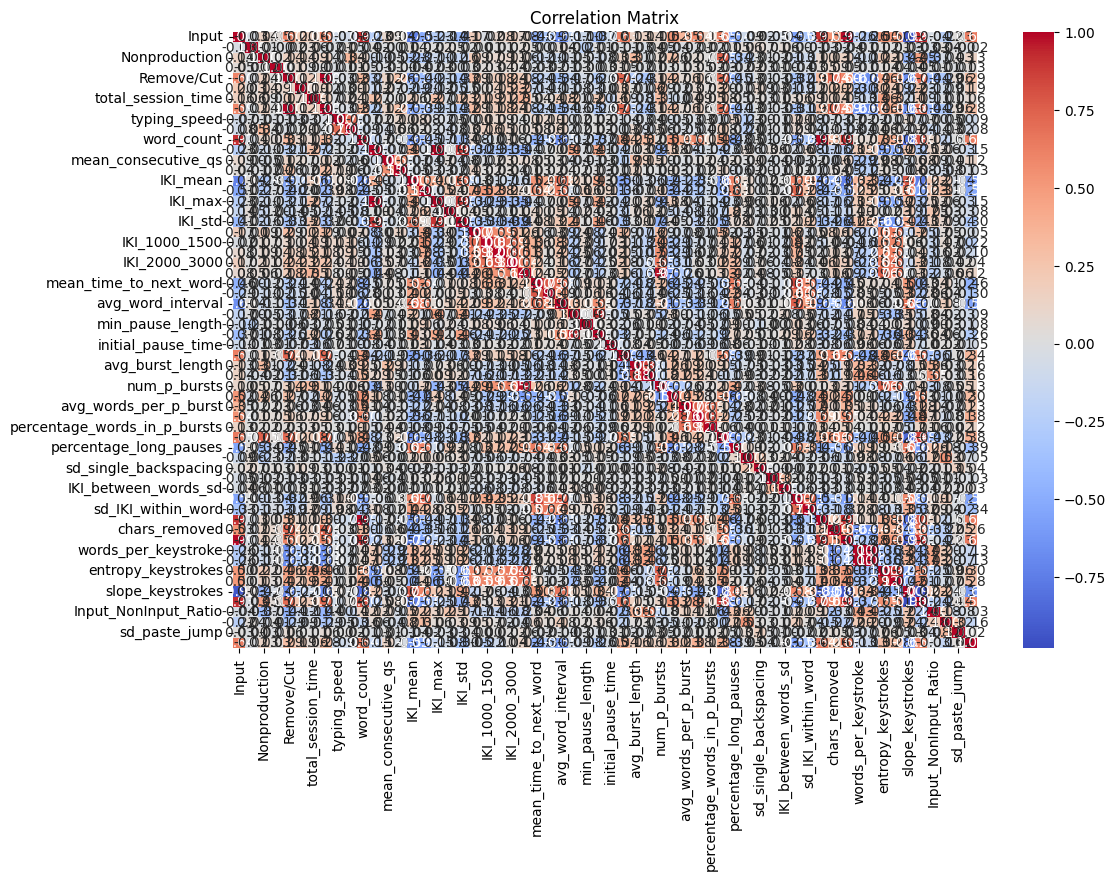

In [40]:
#why not look at the matrix - we won't be able to see much but it's nice to have a picture
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.heatmap(data_for_correlation.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Let's now prepare our data for model fitting by standardising it. Since this is a regression problem with 60 features, we would want to consider models like Linear Regression, Random Forest Regressor, Gradient Boosting Regressor, XGBoost, LightGBM, or SVR. I fitted the data to all of the above and ran hyperparameter optimisation for each one. I found that the Gradient Boosting Regressor had a small but significant advantage over all the other in terms of performance. As our performance metric, we will use the RMSE as suggested in the Kaggle competition.

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Separate the features and the target variable~
X = final_df.drop('id', axis=1)  # Assuming 'id' and 'score' are in the DataFrame
y = data_for_correlation['score']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [42]:
from sklearn.ensemble import GradientBoostingRegressor

# Create the Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state = 42)

# Train the model
gb_model.fit(X_train, y_train)

# Make predictions
y_pred_gb = gb_model.predict(X_test)

# Evaluate the model
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
print("Gradient Boosting - Root Mean Squared Error:", rmse_gb)


Gradient Boosting - Root Mean Squared Error: 0.5900843099324634


As we saw from our correlation scores, some features are much important than others. Let's perform some feature selection with cross-validation.

In [43]:
from sklearn.feature_selection import RFECV

# Create the RFE object and compute a cross-validated score
rfecv = RFECV(estimator=gb_model, step=1, cv=7, scoring='neg_mean_squared_error')
rfecv.fit(X_train, y_train)

print("Optimal number of features: %d" % rfecv.n_features_)

# Get the mask of selected features
selected_features_mask = rfecv.support_

# Print selected features
feature_names = final_df.drop(['id'], axis=1).columns

selected_features = np.array(feature_names)[selected_features_mask]
print("Selected Features:", selected_features)

# Print rankings of all features
all_features_rankings = pd.Series(rfecv.ranking_, index=feature_names)
print(all_features_rankings)

Optimal number of features: 40
Selected Features: ['Input' 'Nonproduction' 'typing_speed' 'content_speed' 'word_count' 'gap'
 'mean_consecutive_qs' 'max_consecutive_qs' 'IKI_median' 'IKI_min'
 'IKI_std' 'IKI_500_1000' 'IKI_1000_1500' 'IKI_1500_2000' 'IKI_3000_inf'
 'mean_time_to_next_word' 'std_time_to_next_word' 'max_pause_length'
 'min_pause_length' 'initial_pause_time' 'num_bursts'
 'avg_words_per_burst' 'num_p_bursts' 'avg_words_per_p_burst'
 'total_words_in_p_bursts' 'mean_single_backspacing'
 'sd_single_backspacing' 'IKI_between_words_sd' 'mean_IKI_within_word'
 'sd_IKI_within_word' 'final_word_count' 'chars_removed'
 'total_typed_chars_count' 'efficiency' 'uniformity_keystrokes'
 'slope_keystrokes' 'total_keystrokes' 'Input_NonInput_Ratio'
 'mean_paste_jump' 'sd_paste_jump']
Input                            1
Move                            18
Nonproduction                    1
Paste                           20
Remove/Cut                      19
Replace                         

In [44]:
#now let's train a GB model with our selected features
# Transform training and testing sets based on selected features
X_train_selected = X_train[:, selected_features_mask]
X_test_selected = X_test[:, selected_features_mask]

# Fit the model with the selected features
gb_model.fit(X_train_selected, y_train)

# Make predictions with the selected features
y_pred_selected = gb_model.predict(X_test_selected)

# Evaluate the model with the selected features
rmse_selected = np.sqrt(mean_squared_error(y_test, y_pred_selected))
print("Gradient Boosting with Selected Features - RMSE:", rmse_selected)


Gradient Boosting with Selected Features - RMSE: 0.5907745757196405


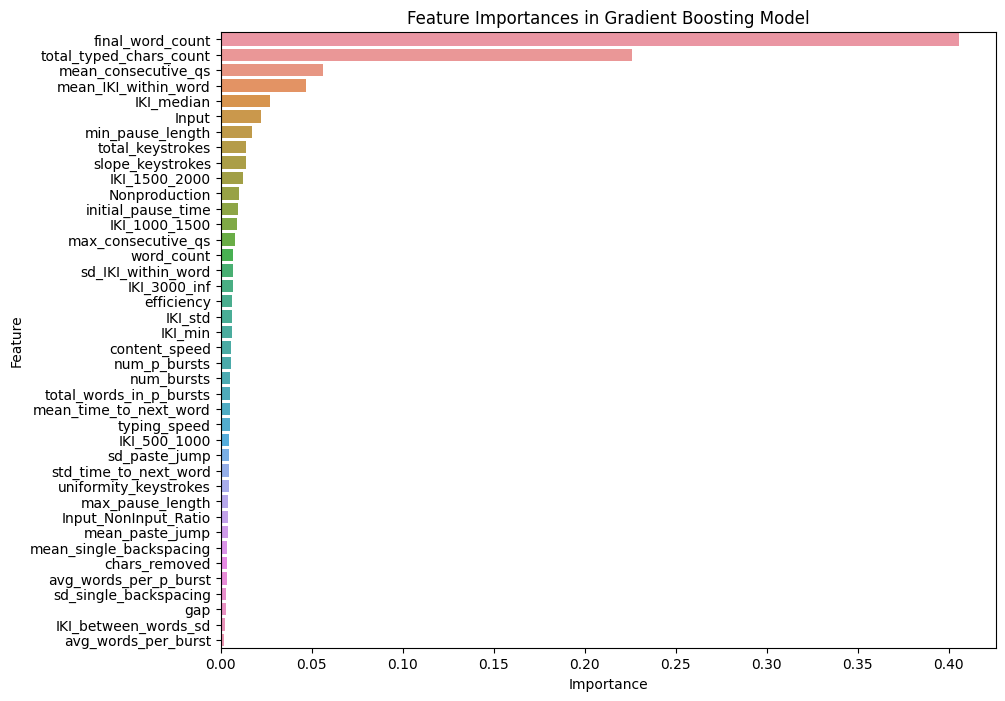

In [45]:
#why don't we visualise the feature importance for fun
# Get feature importances from the fitted model
feature_importances = gb_model.feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances in Gradient Boosting Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


Time for some hyperparameter tuning - I'm going to use Optuna for this.

In [46]:
pip install optuna

In [55]:
import optuna
def objective(trial):
    # Defining the hyperparameter space
    n_estimators = trial.suggest_int('n_estimators', 100, 150)
    max_depth = trial.suggest_int('max_depth', 4, 12)
    min_samples_split = trial.suggest_float('min_samples_split', 0.1, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 9)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.5)
    max_features = trial.suggest_categorical('max_features', [1.0, 'sqrt', 'log2'])
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    loss = trial.suggest_categorical('loss', ['squared_error', 'absolute_error', 'huber'])

    # Training the model
    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        learning_rate=learning_rate,
        max_features=max_features,
        subsample=subsample,
        loss=loss,
        random_state=42
    )
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)

    # Return the evaluation metric
    return np.sqrt(mean_squared_error(y_test, y_pred))

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")




[I 2024-01-11 01:24:52,335] A new study created in memory with name: no-name-b0fd3b6d-a25a-4cff-a276-7d2605283363
[I 2024-01-11 01:24:52,947] Trial 0 finished with value: 0.6249427475558899 and parameters: {'n_estimators': 135, 'max_depth': 4, 'min_samples_split': 0.3444580502565038, 'min_samples_leaf': 9, 'learning_rate': 0.44613711338504963, 'max_features': 'sqrt', 'subsample': 0.8403363687596985, 'loss': 'absolute_error'}. Best is trial 0 with value: 0.6249427475558899.
[I 2024-01-11 01:24:55,997] Trial 1 finished with value: 0.6110340959332604 and parameters: {'n_estimators': 147, 'max_depth': 7, 'min_samples_split': 0.3017354875508053, 'min_samples_leaf': 2, 'learning_rate': 0.2017879509211916, 'max_features': 1.0, 'subsample': 0.6938640726735712, 'loss': 'absolute_error'}. Best is trial 1 with value: 0.6110340959332604.
[I 2024-01-11 01:24:56,117] Trial 2 finished with value: 0.9886358988295042 and parameters: {'n_estimators': 144, 'max_depth': 10, 'min_samples_split': 0.58238598

Best trial:
  Value:  0.5771425030466852
  Params: 
    n_estimators: 105
    max_depth: 9
    min_samples_split: 0.12137782008613779
    min_samples_leaf: 2
    learning_rate: 0.0834500749341584
    max_features: 1.0
    subsample: 0.5175812934445695
    loss: squared_error


In [56]:
#and to finish, let's fit our model with the optimised hyperparameters

# Create the Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators = 105, max_depth = 9, min_samples_split = 0.12137782008613779, min_samples_leaf = 2,
                                     learning_rate = 0.0834500749341584, max_features =  1.0, subsample = 0.5175812934445695, loss = 'squared_error'
    )

# Train the model
gb_model.fit(X_train_selected, y_train)


GradientBoostingRegressor(learning_rate=0.0834500749341584, max_depth=9,
                          max_features=1.0, min_samples_leaf=2,
                          min_samples_split=0.12137782008613779,
                          n_estimators=105, subsample=0.5175812934445695)

We should also note that we preprocessed all the training logs before splitting them into a training and test set for the purposes of training a model, however for practical use, future test logs would need to be preprocessed separately using our preprocess function before being fed into the model. We can write out a function to make prediction on new test logs as below:

In [57]:
def predict(test_logs):
  X_test_set = preprocess(test_logs)
  X_test_set = scaler.fit_transform(X_test_set)
  X_test_set = X_test_set[:, selected_features_mask]
  predicted_scores = gb_model.predict(X_test_set)
  return predicted_scores

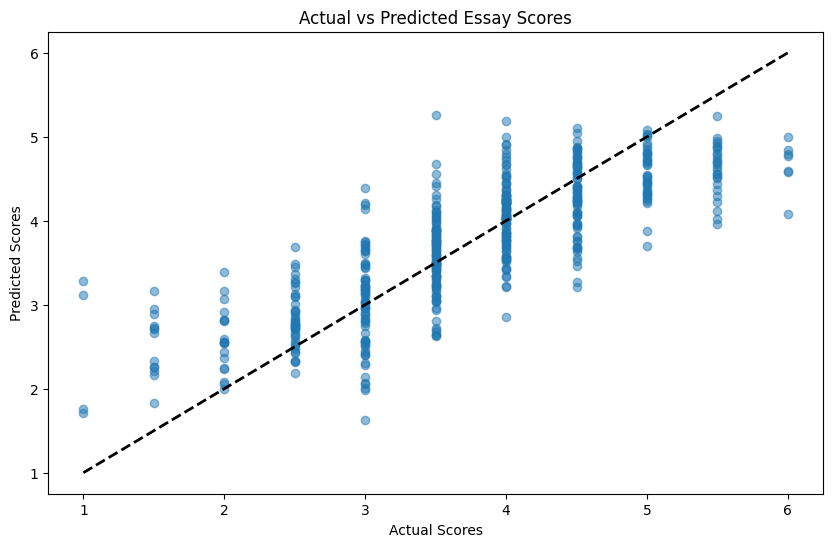

In [59]:
#Finally, let's visualise our predicted scores vs the actual ones

actual_scores = y_test
predicted_scores = y_pred_selected

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(actual_scores, predicted_scores, alpha=0.5)
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Actual vs Predicted Essay Scores')

# Add a line for perfect predictions
plt.plot([actual_scores.min(), actual_scores.max()], [actual_scores.min(), actual_scores.max()], 'k--', lw=2)

plt.show()


As we can see, the model is broadly in the right area when predicting the actual scores, except at the extreme ends of the scoring where it tends to overpredict the lowest scores and underpredict the highest. The last time I checked the public leaderboard for the Kaggle competition, the current winning RMSE value was 0.570, so an RMSE of 0.577 is not terrible given that I worked on my model for just under 2 weeks and the competition has been running for 3 months. In fact, being able to get an acceptable error metric relatively quickly has definitely encouraged me to actually enter and work hard on a Kaggle competition in the future!